# Train new models using new dataset (1500 compounds)

In [1]:
# Autoreload modules
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np

from pandas import DataFrame
from numpy import ndarray
from typing import Union, Any, Dict, Tuple, List

# Local modules
from mrp7pred.utils import (
    DATA, 
    OUTPUT,
    ensure_folder,
    get_current_time,
    plot_roc_auc
)
from mrp7pred.mrp7pred import MRP7Pred
from mrp7pred.grid import grid, grid_light
from mrp7pred.scoring import get_scoring

ALL_FEATURIZED = "../data/all_compounds_828_features.csv"

#### 1. Load data and get basic statistics

In [2]:
df = pd.read_csv(ALL_FEATURIZED, index_col=0)
df.head()

,name,label,smiles,FractionCSP3,HeavyAtomCount,HeavyAtomMolWt,NHOHCount,NOCount,RingCount,NumAliphaticCarbocycles,...,ATSe7,ATSe8,ATSp1,ATSp2,ATSp3,ATSp4,ATSp5,ATSp6,ATSp7,ATSp8
0,paclitaxel,1,CC(=O)OC1C(=O)C2(C)C(O)CC3OCC3(OC(C)=O)C2C(OC(...,0.446809,62.0,802.510,4.0,15.0,7.0,3.0,...,5.327,5.184,4.058,4.421,4.610,4.691,4.805,4.894,4.829,4.748
1,vincristine,1,CCC1(O)CC2CN(CCc3c([nH]c4ccccc34)C(C(=O)OC)(c3...,0.565217,60.0,768.524,3.0,14.0,9.0,1.0,...,5.285,5.159,4.047,4.528,4.759,4.967,4.988,4.985,4.913,4.799
2,LTC4,1,CCCCCC=CCC=CC=CC=CC(SCC(NC(=O)CCC(N)C(=O)O)C(=...,0.566667,43.0,578.409,8.0,12.0,0.0,0.0,...,4.247,4.316,3.625,3.715,3.760,3.789,3.831,3.863,3.902,3.888
3,E217bG,1,CC12CCC3c4ccc(O)cc4CCC3C1CCC2OC1OC(C(=O)O)C(O)...,0.708333,32.0,416.256,5.0,8.0,5.0,3.0,...,3.890,3.811,3.451,3.843,3.915,3.791,3.648,3.590,3.502,3.258
4,gemcitabine,1,Nc1ccn(C2OC(CO)C(O)C2(F)F)c(=O)n1,0.555556,18.0,252.112,4.0,7.0,2.0,0.0,...,2.614,1.615,2.614,2.903,2.835,2.645,2.489,2.138,1.619,0.860


In [3]:
# Check null values
any(df["smiles"].isna())

False

In [4]:
# Check duplicates
len(df["smiles"].values.tolist()) == len(set(df["smiles"].values.tolist()))

False

In [5]:
# Remove duplciates
df_unique = df.drop_duplicates(subset=["smiles"])

In [6]:
# Check again
len(df_unique["smiles"].values.tolist()) == len(set(df_unique["smiles"].values.tolist()))

True

In [7]:
len(df_unique["smiles"].values.tolist()), len(set(df_unique["smiles"].values.tolist()))

(1230, 1230)

In [8]:
df = df_unique.reset_index()

In [9]:
# Check positive / negative
num_1 = len(df[df["label"]==1])
num_0 = len(df[df["label"]==0])
num_1, num_0, round(num_1/num_0, 3)

(129, 1101, 0.117)

In [10]:
df = df.set_index("index")

In [11]:
df.head()

,name,label,smiles,FractionCSP3,HeavyAtomCount,HeavyAtomMolWt,NHOHCount,NOCount,RingCount,NumAliphaticCarbocycles,...,ATSe7,ATSe8,ATSp1,ATSp2,ATSp3,ATSp4,ATSp5,ATSp6,ATSp7,ATSp8
index,,,,,,,,,,,,,,,,,,,,,
0,paclitaxel,1,CC(=O)OC1C(=O)C2(C)C(O)CC3OCC3(OC(C)=O)C2C(OC(...,0.446809,62.0,802.510,4.0,15.0,7.0,3.0,...,5.327,5.184,4.058,4.421,4.610,4.691,4.805,4.894,4.829,4.748
1,vincristine,1,CCC1(O)CC2CN(CCc3c([nH]c4ccccc34)C(C(=O)OC)(c3...,0.565217,60.0,768.524,3.0,14.0,9.0,1.0,...,5.285,5.159,4.047,4.528,4.759,4.967,4.988,4.985,4.913,4.799
2,LTC4,1,CCCCCC=CCC=CC=CC=CC(SCC(NC(=O)CCC(N)C(=O)O)C(=...,0.566667,43.0,578.409,8.0,12.0,0.0,0.0,...,4.247,4.316,3.625,3.715,3.760,3.789,3.831,3.863,3.902,3.888
3,E217bG,1,CC12CCC3c4ccc(O)cc4CCC3C1CCC2OC1OC(C(=O)O)C(O)...,0.708333,32.0,416.256,5.0,8.0,5.0,3.0,...,3.890,3.811,3.451,3.843,3.915,3.791,3.648,3.590,3.502,3.258
4,gemcitabine,1,Nc1ccn(C2OC(CO)C(O)C2(F)F)c(=O)n1,0.555556,18.0,252.112,4.0,7.0,2.0,0.0,...,2.614,1.615,2.614,2.903,2.835,2.645,2.489,2.138,1.619,0.860


Spliting training and test data ... Done!
train_1: 106; train_0: 878; test_1: 23; test_0: 223
Start training ... Fitting 5 folds for each of 14 candidates, totalling 70 fits
[02:35:38] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best model saved to: ../output/model/best_model_20210112-023538.pkl
Best score: 0.8933077799647778
Done!
Best model:
Pipeline(steps=[('sclr', DummyScaler()),
                ('clf',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='',
                               learning_

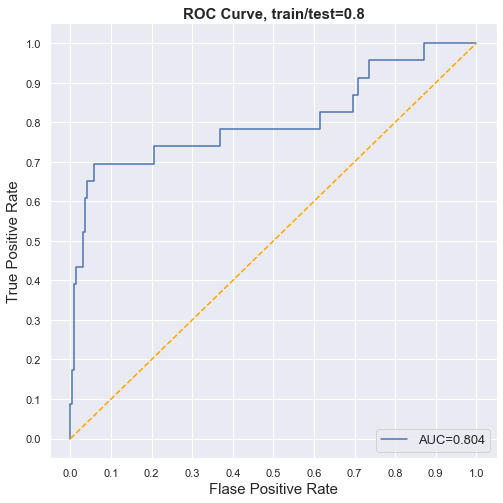

Done!


In [12]:
m7p = MRP7Pred(train_new=True)
m7p.run_train(df, grid=grid_light, train_test_ratio=0.8, featurized=True)